In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib. pyplot as plt 
%matplotlib  inline
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acovf, acf,pacf

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [5]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'dowjones',
 'exercise',
 'flights',
 'fmri',
 'geyser',
 'glue',
 'healthexp',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'seaice',
 'taxis',
 'tips',
 'titanic']

In [13]:
df=sns.load_dataset('flights')
df.columns,df.head()

(Index(['year', 'month', 'passengers'], dtype='object'),
    year month  passengers
 0  1949   Jan         112
 1  1949   Feb         118
 2  1949   Mar         132
 3  1949   Apr         129
 4  1949   May         121)

In [15]:
df['date']=df['year'].astype(str)+'/'+df['month'].astype(str)  # Merge 'year' and 'month' columns
df['date']=pd.to_datetime(df['date'])  # convert into datetime format

df.drop(columns=['year','month'],inplace=True) 

df.set_index('date',inplace=True)  # we will set datetime index

In [17]:
def adf_test(dataFrame,var):  # input-> dataframe and target columns
    """ Dickey fuller test checks for stationarity, if p value is less than 0.005 it is stationary, otherwise it is non-stationary. 
    Input variablesn ara dataframe and target column """
    print ('Dickey-Fuller Test')
    # AIC aims to minimize corresponding information
    dftest = adfuller(dataFrame[var], autolag='AIC') 
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print (dfoutput)
    for key, values in dftest[4].items():
        print('criticality',key,":",values)

In [19]:
adf_test(df,'passengers')

Dickey-Fuller Test
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
dtype: float64
criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


In [21]:
def test_stationarity(dataFrame, var):
    dataFrame['rollMean']  = dataFrame[var].rolling(window=12).mean()
    dataFrame['rollStd']  = dataFrame[var].rolling(window=12).std()
    sns.lineplot(data=dataFrame,x=dataFrame.index,y=var)
    sns.lineplot(data=dataFrame,x=dataFrame.index,y='rollMean')
    sns.lineplot(data=dataFrame,x=dataFrame.index,y='rollStd')

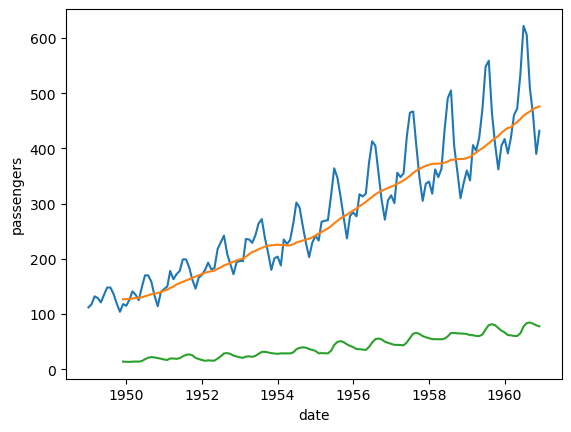

In [23]:
test_stationarity(df,'passengers')

In [27]:
df.columns

Index(['passengers', 'rollMean', 'rollStd'], dtype='object')

In [29]:
a=round(len(df)*75/100)   # we will take 75% of data for train, 25% for test
train=df.iloc[:a]
test=df.iloc[a:,:]

In [77]:
def errors(test_y,new_y):
    """ It calculates Root mean squared error, mean absolute deviation, mean absolute percentage error, and R2 score"""
    rmse=np.sqrt(np.mean((test_y-new_y)**2))
    mad=np.mean(abs(new_y-test_y))
    mape=np.mean(abs(new_y-test_y)/test_y)*100
    y_mean = np.mean(test_y)
    # Calculate the total sum of squares (TSS)
    tss = np.sum((test_y - y_mean)**2)
    # Calculate the residual sum of squares (RSS)
    rss = np.sum((new_y-test_y)**2)
    # Calculate R-squared
    r_squared = 1 - (rss / tss)
    
    
    p3=print("Root mean squared error is",round(rmse,2))
    p4=print("Mean absolute deviation is",round(mad,2))
    p5=print(f"Mean absolute percentage error is {round(mape,2)}%")
    p6=print(f"R-squared: {round(r_squared,2)*100}%")

In [79]:
model=ExponentialSmoothing(train['passengers'],trend='add',seasonal='add',seasonal_periods=12).fit()
# We use exponential smoothing model, here trand and seasonality are additive

pred=model.forecast(steps=len(test))
pred1=model.forecast(steps=len(test)+24)

Root mean squared error is 26.38
Mean absolute deviation is 21.54
Mean absolute percentage error is 5.11%
R-squared: 89.0%


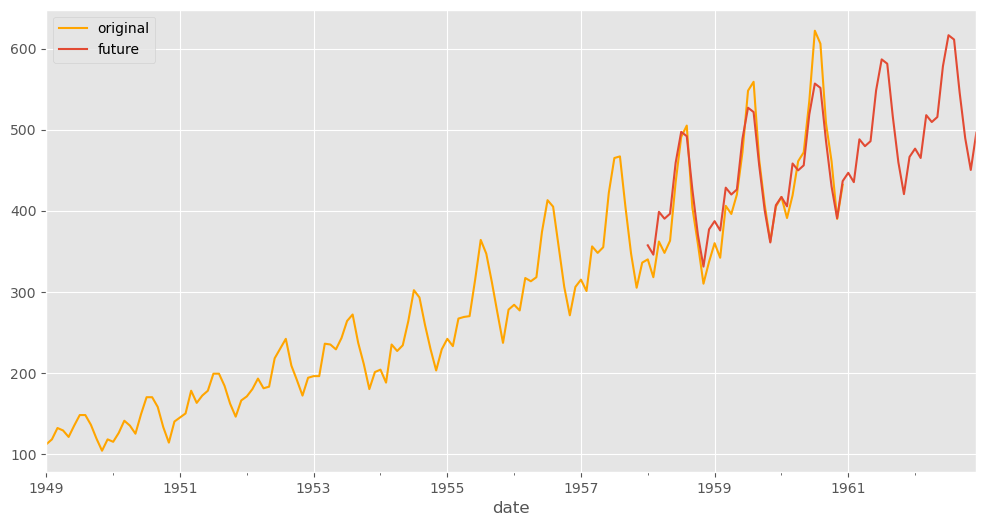

In [85]:
errors(test.passengers,pred)
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
df['passengers'].plot(label='original',color='orange')
#test['passengers'].plot(color='red')
#pred.plot()
pred1.plot(label='future')
plt.legend()
plt.show()

In [89]:
model=AutoReg(train['passengers'],lags=15,trend='ct',seasonal=True,period=12).fit(cov_type='HC0')

pred2=model.forecast(steps=len(test))
pred3=model.forecast(steps=len(test)+24)

Root mean squared error is 18.9
Mean absolute deviation is 15.6
Mean absolute percentage error is 3.83%
R-squared: 94.0%


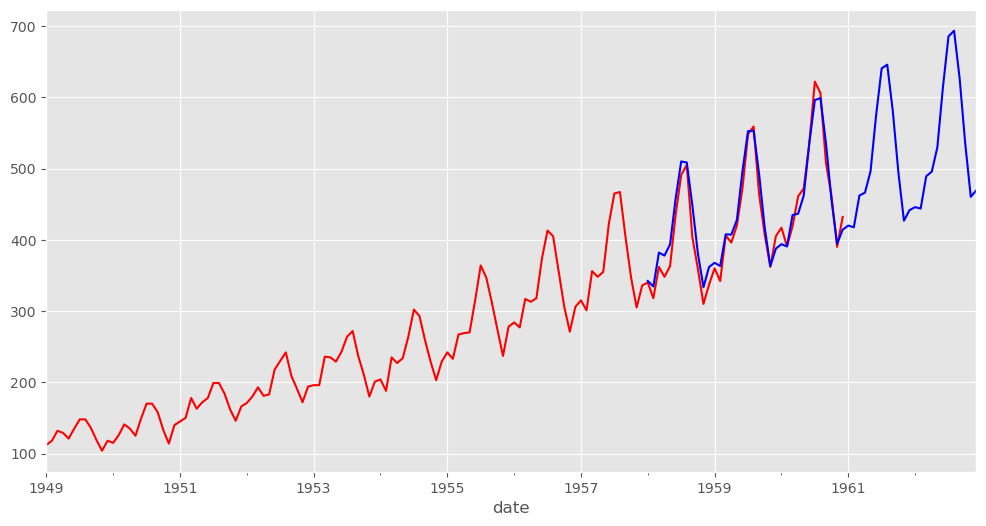

In [91]:
errors(test.passengers,pred2)
plt.figure(figsize=(12,6))
df['passengers'].plot(color='red',label='original')
#test['passengers'].plot(color='red')
#pred2.plot()
pred3.plot(color='blue',label='future')
plt.show()

In [93]:
from statsmodels.tsa.arima_model import ARIMA

In [104]:
import pmdarima as pm
# Load or prepare your time series data
# For example, let's create some sample data
data = df['passengers'].dropna()
# Perform auto ARIMA to find the best parameters
model = pm.auto_arima(data, seasonal=True,stationarity=False)
# Get the best parameters
print("Best p, d, q values:", model.order)

model.fit(data)

pred6=model.predict(n_predictions=12)

Best p, d, q values: (4, 1, 3)


Root mean squared error is nan
Mean absolute deviation is nan
Mean absolute percentage error is nan%
R-squared: 100.0%


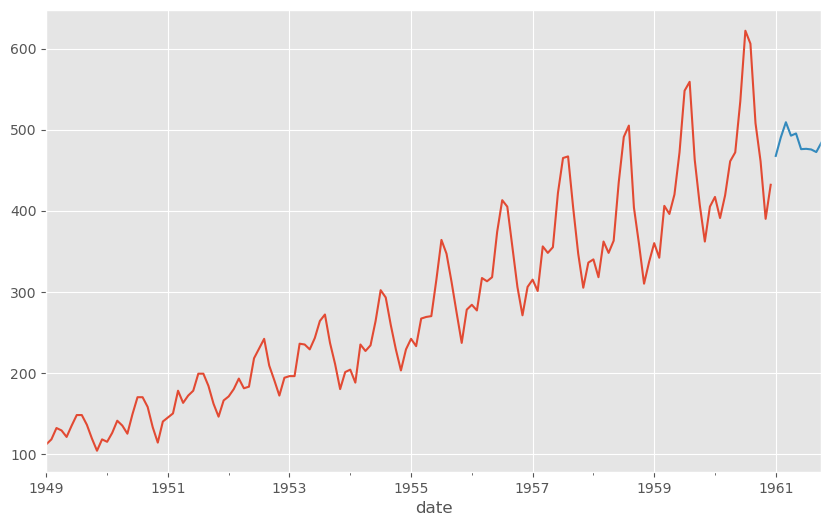

In [105]:
errors(test['passengers'],pred6)
plt.figure(figsize=(10,6))
df['passengers'].plot()
#test['passengers'].plot(color='red')
pred6.plot()
plt.show()

In [108]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model=SARIMAX(train['passengers'],order=(4,1,3),seasonal_order=(4,1,3,12)).fit()

pred7=model.forecast(steps=len(test))

Root mean squared error is 29.34
Mean absolute deviation is 26.42
Mean absolute percentage error is 6.59%
R-squared: 86.0%


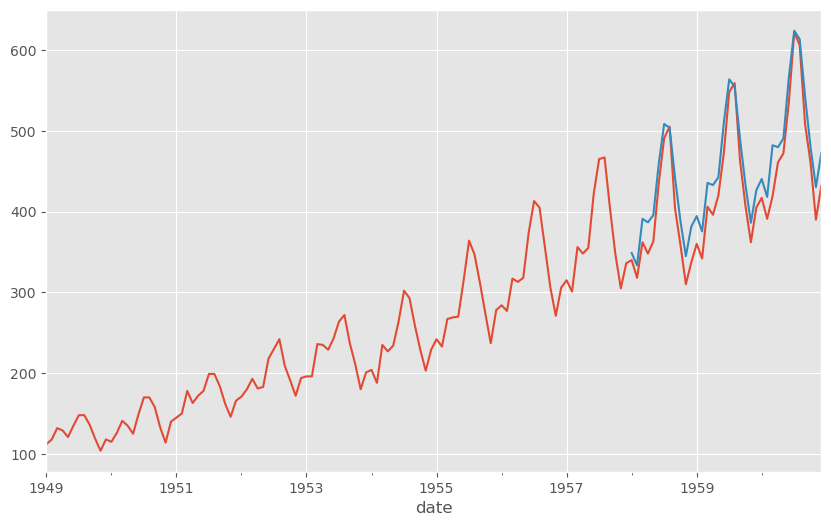

In [124]:
errors(test['passengers'],pred7)
plt.figure(figsize=(10,6))
df['passengers'].plot()
#test['passengers'].plot(color='red')
pred7.plot()
plt.show()